# Regularyzacja

Regularyzacja ogranicza przeuczenie modeli dzięki dodatkowym karom na wagi lub modyfikacjom procesu uczenia. Poniżej znajdują się najpopularniejsze techniki wraz z minimalnymi przykładami, które można uruchomić bezpośrednio w tej notatce.

L2: w = 1.0096632242202759 b = 1.0557111501693726
L1: w = 1.509234070777893 b = 1.0557111501693726


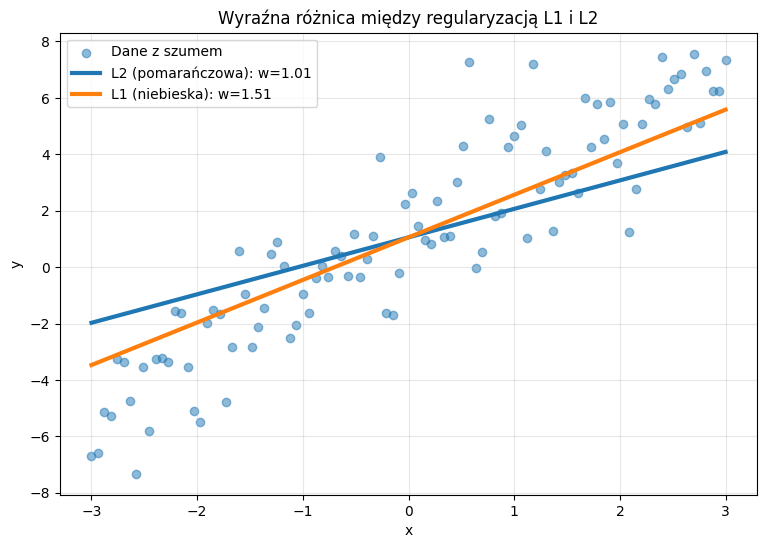

In [2]:
import torch
import matplotlib.pyplot as plt

# ===============================
# 1. Przygotowanie danych
# ===============================
torch.manual_seed(0)

# Dane: prosta y = 2x + 1 + duży szum → lepiej widać L1 vs L2
x = torch.linspace(-3, 3, 100).unsqueeze(1)
y = 2.0 * x + 1.0 + 1.5 * torch.randn_like(x)  # większy szum

# ===============================
# 2. Funkcja trenująca model liniowy
# ===============================
def train(reg_type, lam=3.0, lr=0.05, steps=300
    # losujemu poczatkowe wagi
    w = torch.randn(1, requires_grad=True)
    b = torch.randn(1, requires_grad=True)

    for _ in range(steps):
        y_pred = w * x + b
        loss = torch.mean((y_pred - y)**2)

        # Dodajemy regularyzację
        if reg_type == "l2":
            loss = loss + lam * (w**2)
        else:  # L1
            loss = loss + lam * torch.abs(w)

        # Wsteczna propagacja
        loss.backward()

        # Aktualizacja wag
        with torch.no_grad():
            w -= lr * w.grad
            b -= lr * b.grad

        w.grad.zero_()
        b.grad.zero_()

    return w.item(), b.item()

# ===============================
# 3. Trenowanie modeli L1 i L2
# ===============================
w_l2, b_l2 = train("l2", lam=3.0)
w_l1, b_l1 = train("l1", lam=3.0)

print("L2: w =", w_l2, "b =", b_l2)
print("L1: w =", w_l1, "b =", b_l1)

# ===============================
# 4. Wykres
# ===============================
plt.figure(figsize=(9,6))

# Punkty danych
plt.scatter(x.numpy(), y.numpy(), alpha=0.5, label="Dane z szumem")

# Linie regresji
plt.plot(
    x.numpy(),
    (w_l2 * x + b_l2).detach().numpy(),
    label=f"L2 (pomarańczowa): w={w_l2:.2f}",
    linewidth=3
)

plt.plot(
    x.numpy(),
    (w_l1 * x + b_l1).detach().numpy(),
    label=f"L1 (niebieska): w={w_l1:.2f}",
    linewidth=3
)

plt.title("Wyraźna różnica między regularyzacją L1 i L2")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


L2: w = 1.341745138168335 b = 0.42228466272354126
L1: w = 1.5092341899871826 b = 0.06262729316949844


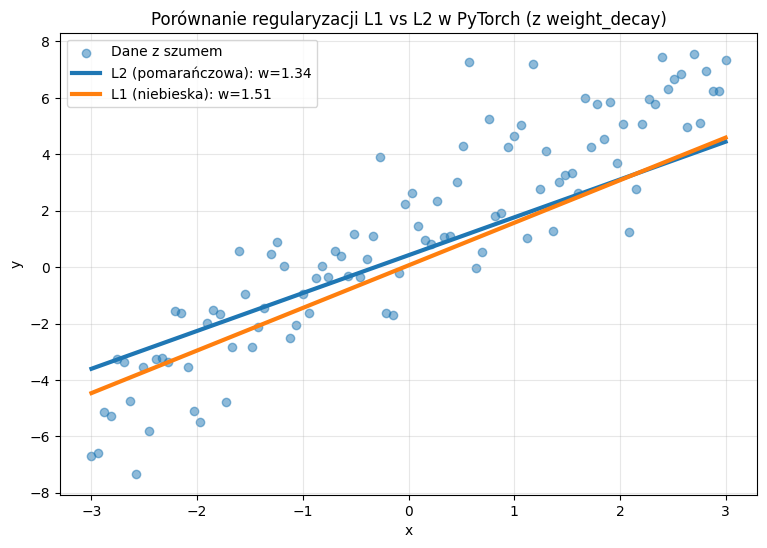

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# ===============================
# 1. Dane
# ===============================
torch.manual_seed(0)

x = torch.linspace(-3, 3, 100).unsqueeze(1)
y = 2.0 * x + 1.0 + 1.5 * torch.randn_like(x)  # duży szum → różnice bardziej widoczne

# ===============================
# 2. Funkcja treningowa
# ===============================
def train(reg_type, lam=3.0, lr=0.05, steps=300):

    model = nn.Linear(1, 1)

    # L2 = weight decay (standard w PyTorch)
    if reg_type == "l2":
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=lam)

    # L1 = trzeba dodać ręcznie
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    loss_fn = nn.MSELoss()

    for _ in range(steps):

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        # L1 penalty (PyTorch nie ma wbudowanej)
        if reg_type == "l1":
            l1_penalty = sum(torch.abs(p).sum() for p in model.parameters())
            loss = loss + lam * l1_penalty

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # extract wagi
    w = model.weight.data.item()
    b = model.bias.data.item()
    return w, b

# ===============================
# 3. Trenowanie modeli
# ===============================
w_l2, b_l2 = train("l2", lam=3.0)
w_l1, b_l1 = train("l1", lam=3.0)

print("L2: w =", w_l2, "b =", b_l2)
print("L1: w =", w_l1, "b =", b_l1)

# ===============================
# 4. Wykres
# ===============================
plt.figure(figsize=(9,6))

plt.scatter(x.numpy(), y.numpy(), alpha=0.5, label="Dane z szumem")

plt.plot(
    x.numpy(),
    (w_l2 * x + b_l2).detach().numpy(),
    label=f"L2 (pomarańczowa): w={w_l2:.2f}",
    linewidth=3
)

plt.plot(
    x.numpy(),
    (w_l1 * x + b_l1).detach().numpy(),
    label=f"L1 (niebieska): w={w_l1:.2f}",
    linewidth=3
)

plt.title("Porównanie regularyzacji L1 vs L2 w PyTorch (z weight_decay)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


## L1

Regularyzacja L1 dodaje do straty sumę wartości bezwzględnych wag: $L = L_{danych} + \lambda \sum_i |w_i|$. Kara zachęca model do wyzerowania nieistotnych parametrów i w naturalny sposób selekcjonuje cechy.

## L2

Regularyzacja L2 karze duże wartości wag: $L = L_{danych} + \lambda \sum_i w_i^2$. W PyTorch wygodnie używa się `weight_decay`, który automatycznie dodaje karę w optymalizatorze i stabilizuje uczenie.



### ✅ **Kiedy używać L1, a kiedy L2? (praktyczny przewodnik)**

#### 🟠 **Użyj L1, jeśli…**

##### ✔ Chcesz automatycznie **wybrać najważniejsze cechy**

L1 wyzerowuje wagi → model sam odrzuca cechy nieistotne.

**Przykład:**
Masz 500 cech, a wiesz, że tylko kilka naprawdę wpływa na wynik.

---

##### ✔ Dane mogą mieć **dużo śmieciowych/niepotrzebnych kolumn**

L1 przeprowadza *feature selection*.

---

##### ✔ Oczekujesz modelu, który ma być **interpretowalny i oszczędny**

Bo w modelu zostaną tylko *te cechy, które mają niezerowe wagi*.

---

##### ✔ Chcesz modelu o **rzadkiej strukturze**

Do kompresji modeli, szybkich modeli, pracy na ograniczonej pamięci.

---

---

# 🔵 **Użyj L2, jeśli…**

##### ✔ Masz dane z **wysokim poziomem szumu**

L2 działa jak wygładzanie → daje stabilniejsze wyniki.

---

##### ✔ Wszystkie cechy powinny być **jakoś użyte**, żadna nie ma znikać

L2 rzadko wyzeruje wagi — będzie korzystać z wszystkich informacji.

---

##### ✔ Chcesz modelu stabilnego, mniej podatnego na wahania

L2 jest bardziej „konserwatywne” i przewidywalne.

---

##### ✔ Budujesz modele oparte na sieciach neuronowych

W deep learning **zawsze używa się L2 (weight decay)**, bo:

* L1 może zatrzymać gradient na 0
* L2 poprawia stabilność

---

### 🧠 **Najkrótsze możliwe podsumowanie:**

* **L1** → jeśli chcesz *wybrać cechy*, uzyskać *rzadkie rozwiązanie*, wyzerować wagi.
* **L2** → jeśli chcesz *stabilność*, *wygładzenie*, *wyższe bezpieczeństwo* w obecności szumu.

---

### 🎯 **Checklist: co wybrać w praktyce?**

| Sytuacja                           | L1 | L2                 |
| ---------------------------------- | -- | ------------------ |
| Dużo cech, chcesz je odsiać        | ✔️ | ❌                  |
| Dane z dużym szumem                | ❌  | ✔️                 |
| Deep learning                      | ❌  | ✔️                 |
| Chcesz interpretować model         | ✔️ | ✔️ (ale L1 lepsze) |
| Dane mają nieistotne kolumny       | ✔️ | ❌                  |
| Stabilność ważniejsza od rzadkości | ❌  | ✔️                 |

---

### 🎓 Najprostsza zasada dla uczestników Twojego szkolenia:

**Jeśli nie wiesz — zacznij od L2.
Jeśli masz dużo cech i chcesz uprościć model — użyj L1.**



## Dropout

Dropout losowo wyłącza aktywacje neuronów podczas uczenia (np. 50% wejść ustawia na zero), co zapobiega nadmiernemu poleganiu na pojedynczych cechach. W trybie ewaluacji warstwa przepuszcza sygnał bez zmian.

Wejście:
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
Tryb train (część wartości wyzerowana):
 tensor([[2., 0., 0., 2.],
        [2., 0., 0., 2.],
        [2., 2., 2., 0.]])
Tryb eval (bez losowania):
 tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


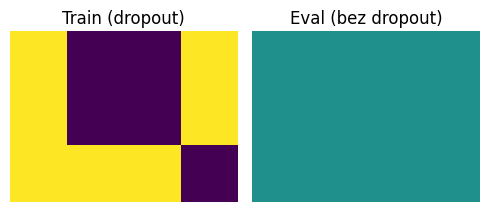

In [7]:
import torch
import torch.nn as nn
# Definiujemy warstwę dropout i prosty tensor wejściowy
drop_layer = nn.Dropout(p=0.5)
sample = torch.ones(3, 4)

# Tryb treningowy losuje maskę i zeruje część wartości
drop_layer.train()
torch.manual_seed(0)
train_pass = drop_layer(sample)

# W trybie ewaluacji dropout niczego nie zeruje
drop_layer.eval()
eval_pass = drop_layer(sample)

print("Wejście:\n", sample)
print("Tryb train (część wartości wyzerowana):\n", train_pass)
print("Tryb eval (bez losowania):\n", eval_pass)

# Prosta wizualizacja masek w obu trybach
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
axes[0].imshow(train_pass.detach().numpy(), cmap='viridis', vmin=0, vmax=2)
axes[0].set_title('Train (dropout)')
axes[1].imshow(eval_pass.detach().numpy(), cmap='viridis', vmin=0, vmax=2)
axes[1].set_title('Eval (bez dropout)')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

### Wnioski Dropout
- Podczas uczenia połowa elementów zostaje wyzerowana, co widać na heatmapie; sieć nie może więc polegać na pojedynczych aktywacjach.
- W trybie ewaluacji maska jest wyłączona, a aktywacje są skalowane, dzięki czemu predykcje są stabilne mimo losowości w treningu.

## Early Stopping

Early stopping monitoruje stratę walidacyjną i kończy trening, gdy brak poprawy przez kilka epok. Dzięki temu model przestaje się uczyć zanim zacznie zapamiętywać szum.

Wczesne zatrzymanie po epoce 54
Najlepsza strata walidacyjna: 0.1276
Historia strat: [2.258, 2.0092, 1.7986, 1.6182, 1.4621, 1.3257, 1.2056, 1.0992, 1.0043, 0.9193, 0.8428, 0.7738, 0.7114, 0.6548, 0.6034, 0.5567, 0.5142, 0.4755, 0.4403, 0.4082, 0.3791, 0.3525, 0.3284, 0.3064, 0.2865, 0.2684, 0.2521, 0.2373, 0.2239, 0.2119, 0.201, 0.1913, 0.1825, 0.1747, 0.1678, 0.1616, 0.1561, 0.1513, 0.1471, 0.1434, 0.1403, 0.1375, 0.1352, 0.1333, 0.1317, 0.1304, 0.1294, 0.1286, 0.1281, 0.1277, 0.1276, 0.1276, 0.1278, 0.1281]


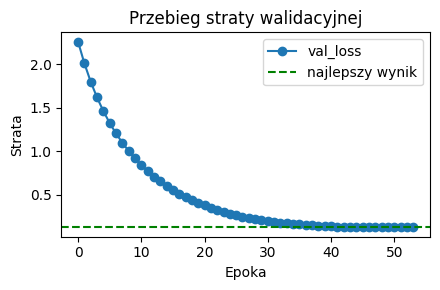

In [8]:
import torch
import torch.nn as nn

# Model liniowy z prostą logiką wczesnego zatrzymywania
model_es = nn.Linear(1, 1)
optimizer = torch.optim.SGD(model_es.parameters(), lr=0.1)
patience = 3
since_best = 0
best_loss = float('inf')
# Przechowujemy najlepszy stan wag, aby móc do niego wrócić
best_state = {k: v.clone() for k, v in model_es.state_dict().items()}
val_history = []

for epoch in range(100):
    optimizer.zero_grad()
    preds = model_es(train_X)
    loss = torch.nn.functional.mse_loss(preds, train_y)
    loss.backward()
    optimizer.step()

    # Obliczamy stratę walidacyjną i porównujemy ją z najlepszym wynikiem
    with torch.no_grad():
        val_loss = torch.nn.functional.mse_loss(model_es(val_X), val_y).item()
    val_history.append(val_loss)

    if val_loss < best_loss - 1e-4:
        best_loss = val_loss
        best_state = {k: v.clone() for k, v in model_es.state_dict().items()}
        since_best = 0
    else:
        since_best += 1
        if since_best == patience:
            print(f"Wczesne zatrzymanie po epoce {epoch + 1}")
            break
else:
    print("Patience nie została wyczerpana")

model_es.load_state_dict(best_state)
print(f"Najlepsza strata walidacyjna: {best_loss:.4f}")
print("Historia strat:", [round(v, 4) for v in val_history])

plt.figure(figsize=(4.5, 3))
plt.plot(val_history, marker='o', label='val_loss')
plt.axhline(best_loss, color='green', linestyle='--', label='najlepszy wynik')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.title('Przebieg straty walidacyjnej')
plt.legend()
plt.tight_layout()
plt.show()

### Wnioski Early Stopping
- Strata walidacyjna stabilizuje się po kilku epokach, dlatego mechanizm przerywa trening zanim zacznie rosnąć.
- Przywrócenie najlepszych wag zapewnia, że finalny model działa w punkcie minimalnej straty walidacyjnej, nawet jeśli ostatnia epoka była gorsza.

## Augmentacja

Augmentacja danych tworzy dodatkowe próbki poprzez modyfikację istniejących wejść (np. odbicie, rotacja, dodanie szumu). Dzięki temu model widzi więcej wariantów i uczy się cech odpornych na drobne zmiany.

Oryginał:
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
Odbicie poziome:
 tensor([[ 3.,  2.,  1.,  0.],
        [ 7.,  6.,  5.,  4.],
        [11., 10.,  9.,  8.],
        [15., 14., 13., 12.]])
Rotacja o 90 stopni:
 tensor([[ 3.,  7., 11., 15.],
        [ 2.,  6., 10., 14.],
        [ 1.,  5.,  9., 13.],
        [ 0.,  4.,  8., 12.]])
Dodanie szumu:
 tensor([[-0.3100,  0.8500,  1.8700,  2.6800],
        [ 3.9800,  4.8800,  5.8000,  6.6800],
        [ 7.8600,  9.0600,  9.8400, 10.9500],
        [11.9600, 13.3400, 14.0500, 15.0900]])


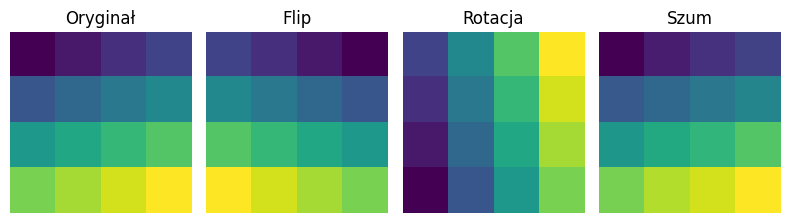

In [4]:
import torch
import torch.nn as nn
# Prosty "obraz" zapisany jako tensor 4x4 i kilka augmentacji
torch.manual_seed(1)
image = torch.arange(0, 16).float().view(1, 4, 4)

flipped = torch.flip(image, dims=[2])  # Odbicie w poziomie
rotated = torch.rot90(image, k=1, dims=[1, 2])  # Obrót o 90 stopni
noisy = image + 0.2 * torch.randn_like(image)  # Dodanie szumu gaussowskiego

print("Oryginał:\n", image[0])
print("Odbicie poziome:\n", flipped[0])
print("Rotacja o 90 stopni:\n", rotated[0])
print("Dodanie szumu:\n", torch.round(noisy[0] * 100) / 100)

fig, axes = plt.subplots(1, 4, figsize=(8, 2.5))
variations = [
    (image[0].numpy(), 'Oryginał'),
    (flipped[0].numpy(), 'Flip'),
    (rotated[0].numpy(), 'Rotacja'),
    (noisy[0].numpy(), 'Szum')
]
for ax, (img, title) in zip(axes, variations):
    ax.imshow(img, cmap='viridis')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Wnioski Augmentacja
- Każda z prostych transformacji generuje nowy wariant tego samego obrazu, co zwiększa różnorodność zbioru treningowego bez zbierania dodatkowych danych.
- Nawet niewielki szum lub odbicie uczy model odporności na drobne zmiany, co pełni funkcję regularyzacji na poziomie danych.

In [5]:
!python --version

Python 3.11.13
